<a href="https://colab.research.google.com/github/brendo-k/Neural_Network_Image_Classifier/blob/master/COMP_551_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General
---


## Steps to train an image classifier

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a neural network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

# Multilayer Perceptron

---

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

 1 Defining Layer classes


In [0]:
class Layer:  # defines a single layer
  
  def __init__(self, input_nodes, output_nodes, learning = 0.01):
    self.W = np.random.rand(input_nodes + 1, output_nodes)
    self.W *= 2
    self.W -= 1
    self.lr = learning
    self.dW = np.zeros([self.W.shape[0], self.W.shape[1]])
    

  def feedforward(self, input): # performs and returns: output = W * (input + b)
    input = np.append(input, np.ones([input.shape[0], 1]), axis=1) #need to append ones to the input for the bias
    return np.dot(input, self.W) #output after this layer

  def backprop(self, input, grad_out, learning, beta):
    nodeWeights = self.W.T[:, :-1] #remove the weights associated with the bias
    gradient_out = np.dot(grad_out, nodeWeights) #d/dX
    input = np.append(input, np.ones([input.shape[0], 1]), axis=1) #appending ones to the input for bias
    self.dW = (1-beta)*np.dot(input.T, grad_out)+beta*(self.dW) #d/dW with momentum
    self.W -= self.lr * self.dW #gradient descent with learning rate

    return gradient_out



In [0]:
class ReLU(): # defines ReLU act. fun. application (can be own layer)
 
  def feedforward(self,input): # apply activation fun
    return np.maximum(0,input) #output after going through this activation function

  def backprop(self, input, grad_out, learning, beta): # grad of loss w.r.t input
    grad = input > 0 #derivative of ReLU
    return grad_out*grad #propagate backwards

In [0]:
class sigmoid():  # defines sigmoid act. fun. application (can be own layer)
 
  def feedforward(self,input): # apply activation fun
    return 1/(1 + np.exp(-input)) #output 

  def backprop(self, input, grad_out, learning, beta): # grad of loss w.r.t input
    return self.feedforward(input)*(1-self.feedforward(input)) * grad_out #propagate backwards

In [0]:
class tanh():
  def feedforward(self, input):
      return (np.exp(input)-np.exp(-input))/(np.exp(input)+np.exp(-input)) #output

  def backprop(self, input, grad_out, learning, beta): # grad of loss w.r.t input 
    return (1-((np.exp(input)-np.exp(-input))/(np.exp(input)+np.exp(-input)))**2)*grad_out #propagate backwards

In [0]:
class loss_funs: # log-softmax gives better numerical stability, easier to get deriv, faster to compute
  
  def softmax_log_ce(logits,real_y):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)),real_y]
    ce_loss = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    return ce_loss #loss
  def grad_softmax_log_ce(logits,realY):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),realY] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True) # softmax so sum to 1
    return (- ones_for_answers + softmax) / logits.shape[0] 

MLP methods

In [0]:
def forward(mlp, X): #
  activations = []
  for layer in mlp:
    act = layer.feedforward(X)
    if(isinstance(layer, Layer)):
      act = normalize(act)
    activations.append(act)
    X = activations[-1]
  return activations

In [0]:
def predict(mlp, x):
  probabilities = soft_max(forward(mlp, x)[-1])
  return np.argmax(probabilities, axis=1)

In [0]:
def miniBatchSGD(x, y, mlp, epoch_runs, lr=.01, eps=1e-2, bsize=8, beta=.90):
  subsampleX = x
  subsampleY = y
  loss = []
  epoch = 0
  epoch_loss = []
  train_acc =[]
  while (epoch < epoch_runs):

    minibatch = np.random.randint(subsampleX.shape[0], size=(bsize))
    batchX = subsampleX[minibatch]
    batchY = subsampleY[minibatch]
    subsampleX = np.delete(subsampleX, minibatch, axis=0)
    subsampleY = np.delete(subsampleY, minibatch, axis=0)
    loss.append(train(mlp, batchX, batchY, lr, beta))
    if(subsampleX.shape[0] == 0):
      subsampleX = x
      subsampleY = y
      epoch += 1
      epoch_loss.append(np.average(loss))
      loss = []
      y_train = predict(mlp, x)
      train_acc.append(getAccuracy(y_train, y))
      

    
  return train_acc, epoch_loss
    



In [0]:
def train(mlp, x, y, lr, beta):
  activation = forward(mlp, x)
  activation = [x] + activation
  loss = loss_funs.softmax_log_ce(soft_max(activation[-1]), y)
  loss_grad = loss_funs.grad_softmax_log_ce(activation[-1], y)
  for i in range(len(mlp))[::-1]:
    
    loss_grad = mlp[i].backprop(activation[i], loss_grad, lr, beta)
  return np.average(loss)

In [0]:
def soft_max(input): #softmax function of last activation layer
  softmax = np.exp(input)
  normalize = np.sum(np.exp(input), axis=1)
  softmax = softmax.T / normalize
  softmax = softmax.T
  return softmax
    

In [0]:
def normalize(input): #normalizes data
  u = np.mean(input, axis=0)
  sig = np.std(input, axis=0)
  sig = sig+0.001
  return (input-u)/sig

Loading the dataset

In [0]:
trainX = trainset.data.reshape([trainset.data.shape[0], -1])
testX = testset.data.reshape([testset.data.shape[0], -1])
trainlabels = np.asarray(trainset.targets)
testlabels = np.asarray(testset.targets)
trainX = trainX - np.mean(trainX, axis=0)
trainX = trainX/(np.std(trainX, axis=0))
testX = testX - np.mean(testX, axis=0)
testX = testX/(np.std(testX, axis=0))
print(testX.shape)

(10000, 3072)


Validation Set

In [0]:
valIndecies = np.random.randint(trainX.shape[0], size = 1000) #picking 1000 random indecies
valX = trainX[valIndecies] #pick the data from the train set
valLabels = trainlabels[valIndecies] #pick the lavells from the train set
trainX = np.delete(trainX, valIndecies, axis=0) #remove the validation data 
trainlabels = np.delete(trainlabels, valIndecies, axis = 0) #remove the validation labels

Training the data test and testing on validation set

In [0]:
import time
batchSize = 512
epoch = 100
trainacc = []
trainloss =[]
valacc = []
valLoss = []

mlp = []
mlp.append(Layer(trainX.shape[1], 100))
mlp.append(ReLU())
mlp.append(Layer(100, 10))

# mlp_r_2 = []
# mlp_r_2.append(Layer(trainX.shape[1], 500))
# mlp_r_2.append(ReLU())
# mlp_r_2.append(Layer(500, 300))
# mlp_r_2.append(ReLU())
# mlp_r_2.append(Layer(300, 10))

t1 = time.time()
for i in range(epoch):
  [acc, loss] = miniBatchSGD(trainX,trainlabels, mlp_r_2, 1, bsize=batchSize)
  trainacc.append(acc[0])
  trainloss.append(loss[0])
  activation = soft_max(forward(mlp_r_2, valX)[-1])
  y_hat = np.argmax(activation, axis = 1)
  valacc.append(getAccuracy(y_hat, valLabels))
  valLoss.append(loss_funs.softmax_log_ce(activation, valLabels))


t2 = time.time()
print(t2-t1)


3428.104079723358


Plotting accuracy vs epoch 

0.3405


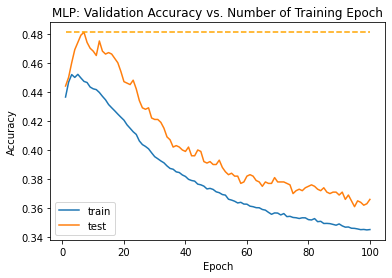

In [0]:
y = predict(mlp_r_2, testX)
print(getAccuracy(y, testlabels))
plt.plot(np.linspace(1, epoch, epoch), trainacc, label = "train")
plt.plot(np.linspace(1, epoch, epoch), valacc, label = "test")
plt.plot(np.arange(1, epoch+1), np.full([len(valacc)], valacc[np.argmax(valacc)]), color="orange", linestyle="--")
plt.title("MLP: Validation Accuracy vs. Number of Training Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Plotting loss vs epoch

0.3405


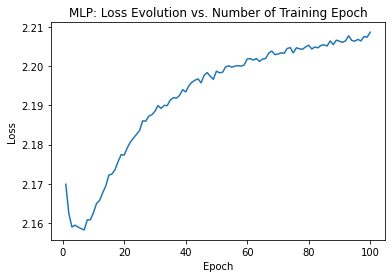

In [0]:
y = predict(mlp_r_2, testX)
print(getAccuracy(y, testlabels))
plt.plot(np.linspace(1, epoch, epoch), trainloss, label = "train")
#plt.plot(np.linspace(1, epoch, epoch), valLoss, label = "test")
#plt.plot(np.arange(1, epoch+1), np.full([len(valLoss)], valLoss[np.argmin(valLoss)]), color="orange", linestyle="--")
plt.title("MLP: Loss Evolution vs. Number of Training Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

####Defining the Multi Layer Perceptron as a **list**
Different models selection

In [0]:
mlp_r_1 = []
mlp_r_1.append(Layer(trainX.shape[1], 100))
mlp_r_1.append(ReLU())
mlp_r_1.append(Layer(100, 10))

mlp_r_2 = []
mlp_r_2.append(Layer(trainX.shape[1], 500))
mlp_r_2.append(ReLU())
mlp_r_2.append(Layer(500, 300))
mlp_r_2.append(ReLU())
mlp_r_2.append(Layer(300, 10))

mlp_r_3 = []
mlp_r_3.append(Layer(trainX.shape[1], 600))
mlp_r_3.append(ReLU())
mlp_r_3.append(Layer(600, 300))
mlp_r_3.append(ReLU())
mlp_r_3.append(Layer(300, 100))
mlp_r_3.append(ReLU())
mlp_r_3.append(Layer(100, 10))

mlp_r_4 = []
mlp_r_4.append(Layer(trainX.shape[1], 700))
mlp_r_4.append(ReLU())
mlp_r_4.append(Layer(700, 400))
mlp_r_4.append(ReLU())
mlp_r_4.append(Layer(400, 200))
mlp_r_4.append(ReLU())
mlp_r_4.append(Layer(200, 50))
mlp_r_4.append(ReLU())
mlp_r_4.append(Layer(50, 10))

mlp_s_1 = []
mlp_s_1.append(Layer(trainX.shape[1], 100))
mlp_s_1.append(sigmoid())
mlp_s_1.append(Layer(100, 10))

mlp_s_2 = []
mlp_s_2.append(Layer(trainX.shape[1], 500))
mlp_s_2.append(sigmoid())
mlp_s_2.append(Layer(500, 300))
mlp_s_2.append(sigmoid())
mlp_s_2.append(Layer(300, 10))

mlp_s_3 = []
mlp_s_3.append(Layer(trainX.shape[1], 600))
mlp_s_3.append(sigmoid())
mlp_s_3.append(Layer(600, 300))
mlp_s_3.append(sigmoid())
mlp_s_3.append(Layer(300, 100))
mlp_s_3.append(sigmoid())
mlp_s_3.append(Layer(100, 10))

mlp_s_4 = []
mlp_s_4.append(Layer(trainX.shape[1], 700))
mlp_s_4.append(sigmoid())
mlp_s_4.append(Layer(700, 400))
mlp_s_4.append(sigmoid())
mlp_s_4.append(Layer(400, 200))
mlp_s_4.append(sigmoid())
mlp_s_4.append(Layer(200, 50))
mlp_s_4.append(sigmoid())
mlp_s_4.append(Layer(50, 10))

mlp_t_1 = []
mlp_t_1.append(Layer(trainX.shape[1], 100))
mlp_t_1.append(tanh())
mlp_t_1.append(Layer(100, 10))

mlp_t_2 = []
mlp_t_2.append(Layer(trainX.shape[1], 500))
mlp_t_2.append(tanh())
mlp_t_2.append(Layer(500, 300))
mlp_t_2.append(tanh())
mlp_t_2.append(Layer(300, 10))

mlp_t_3 = []
mlp_t_3.append(Layer(trainX.shape[1], 600))
mlp_t_3.append(tanh())
mlp_t_3.append(Layer(600, 300))
mlp_t_3.append(tanh())
mlp_t_3.append(Layer(300, 100))
mlp_t_3.append(tanh())
mlp_t_3.append(Layer(100, 10))

mlp_t_4 = []
mlp_t_4.append(Layer(trainX.shape[1], 700))
mlp_t_4.append(tanh())
mlp_t_4.append(Layer(700, 400))
mlp_t_4.append(tanh())
mlp_t_4.append(Layer(400, 200))
mlp_t_4.append(tanh())
mlp_t_4.append(Layer(200, 50))
mlp_t_4.append(tanh())
mlp_t_4.append(Layer(50, 10))



In [0]:
import time
batchSize = 500
epoch = 6
def pred(mlp): 
  [accuracy, loss] = miniBatchSGD(trainX,trainlabels,mlp, epoch, bsize=batchSize)
  y = predict(mlp, testX)
  plt.plot(np.linspace(1, epoch, epoch), loss)
  plt.show()
  return getAccuracy(y, testlabels)

In [0]:
def getAccuracy(predicted, actual):
  TP = 0;
  FN = 0;
  for i in range(len(predicted)):
    if(predicted[i] == actual[i]):
      TP += 1
    FN += 1
  return TP/FN

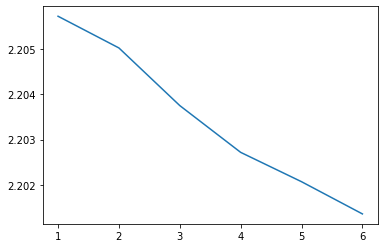

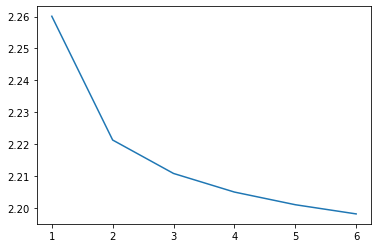

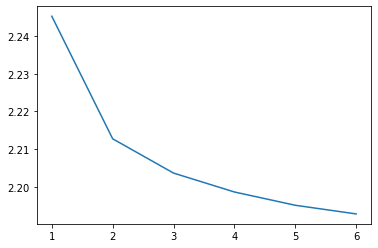

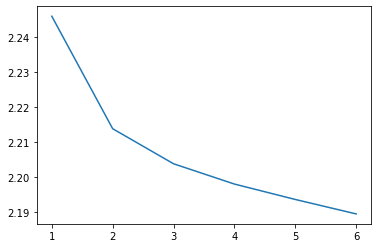

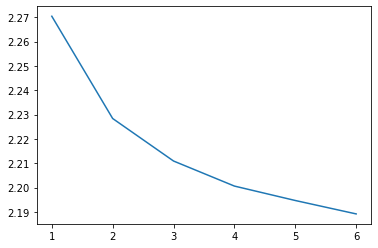

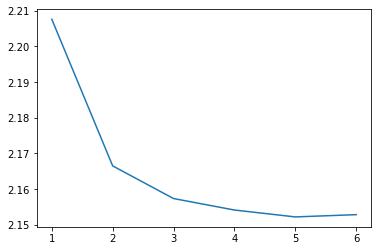

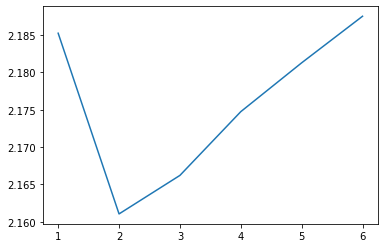

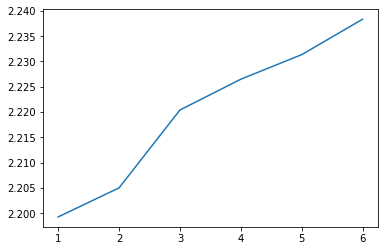

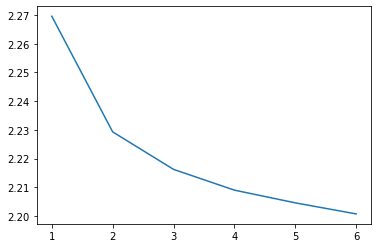

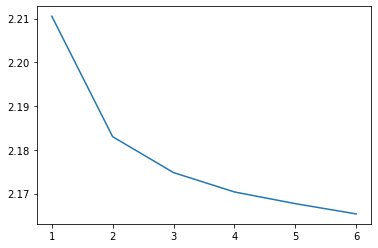

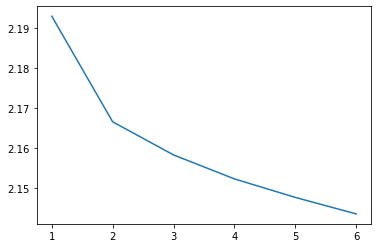

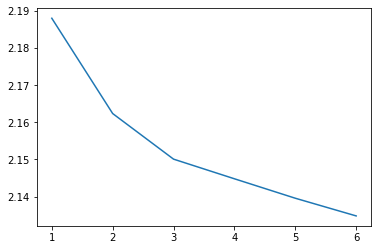

In [0]:
sig_iter_depth = [pred(mlp_s_1), pred(mlp_s_2), pred(mlp_s_3), pred(mlp_s_4)]
relu_iter_depth = [pred(mlp_r_1), pred(mlp_r_2), pred(mlp_r_3), pred(mlp_r_4)]
tanh_iter_depth = [pred(mlp_t_1), pred(mlp_t_2), pred(mlp_t_3), pred(mlp_t_4)]

[0.4699397324709687, 0.5860428231562252, 0.6134236850596967, 0.6515276630883567]
[0.6223231667748216, 0.8050541516245487, 0.5590894917368257, 0.34012329134280356]


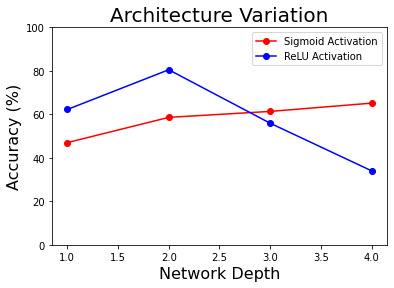

[0.3548, 0.3591, 0.3689, 0.3792]
[0.3689, 0.4487, 0.3817, 0.2749]
[0.3576, 0.4197, 0.4448, 0.4597]


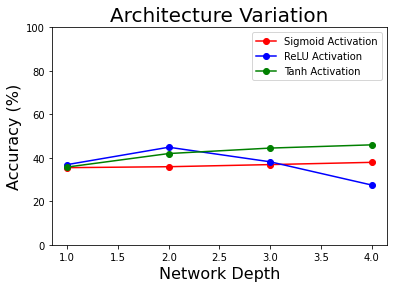

<Figure size 432x288 with 0 Axes>

In [0]:
print(sig_iter_depth)
print(relu_iter_depth)
print(tanh_iter_depth)

x = [1,2,3,4]
sig_val = np.dot(sig_iter_depth,100)
relu_val = np.dot(relu_iter_depth,100)
tanh_val = np.dot(tanh_iter_depth,100)
axes = plt.gca()
axes.set_ylim([0,100])
plt.plot(x, sig_val, 'ro-', label='Sigmoid Activation')
plt.plot(x, relu_val, 'bo-', label='ReLU Activation')
plt.plot(x, tanh_val, 'go-', label='Tanh Activation')
#plt.xticks(x, x)
plt.xlabel('Network Depth', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=16)
plt.title('Architecture Variation', fontsize=20)
plt.legend()
plt.show()
plt.savefig('Depth_ActFun.pdf') 

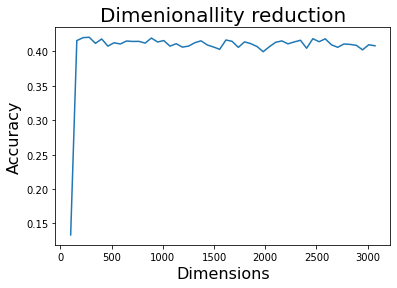

In [0]:
from sklearn.decomposition import PCA

epoch = 20
batchSize = 512
accuracy = []

for n_components in np.linspace(1, 3072, 50, dtype=int):
  pca = PCA(n_components=n_components).fit(trainX)
  trainX_pca = pca.transform(trainX)
  testX_pca = pca.transform(testX)
  mlp = []
  mlp.append(Layer(trainX_pca.shape[1], 100))
  mlp.append(ReLU())
  mlp.append(Layer(100, 10))


  for i in range(epoch):
    [acc, loss] = miniBatchSGD(trainX_pca,trainlabels, mlp, 1, bsize=batchSize)
  pred_labels = predict(mlp, testX_pca)
  accuracy.append(getAccuracy(pred_labels, testlabels))

plt.plot(np.linspace(100, 3072, 50, dtype=int), accuracy)
plt.ylabel("Accuracy", fontsize = 16)
plt.xlabel("Dimensions", fontsize = 16)
plt.title("Dimensionality reduction", fontsize = 20)
plt.show()



In [0]:
from sklearn.metrics import confusion_matrix

batchSize = 512
epoch = 40
mlp = []
mlp.append(Layer(trainX.shape[1], 100))
mlp.append(ReLU())
mlp.append(Layer(100, 10))

miniBatchSGD(trainX,trainlabels, mlp, 40, bsize=batchSize)
  
labels = predict(mlp, testX)



NameError: ignored

In [0]:
matrix = confusion_matrix(testlabels, labels)
accuracy = np.diag(matrix)/np.sum(matrix, axis = 1)
img_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.bar(img_labels, accuracy)
plt.title("Class accuracy MLP", fontsize=16)
plt.xlabel("Classes", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.xticks(img_labels)



# Convolutional Neural Network

---



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

##1. Loading the dataset and output a dictionary (data matrix, label index)

In [0]:
BATCH_SIZE = 512
n_training_acc = 0

# normalization
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load the raw training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# training accuracy
#train_sub = torch.utils.data.Subset(trainset, range(n_training_acc))
#train_sub_Loader = torch.utils.data.DataLoader(train_sub, batch_size=BATCH_SIZE)

# create an iterable training dataset
#trainset = torch.utils.data.Subset(trainset, range(n_training_acc, len(trainset)))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# load the raw test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# create an iterable test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


##2. Creating the CNN

In [0]:
import torch.nn as nn   # torch.nn.Module corresponds to the base class for all neural networks
import torch.nn.functional as F   # contains convolution functions

p = 0.5

class Net(nn.Module):
    def __init__(self):
        super(Net, self, ).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # 1st filter layer: torch.nn.Conv2d(in_channels, out_channels, kernel_size). 5x5x3
        self.pool = nn.MaxPool2d(2, 2)    # pooling layer: nn.MaxPool2d(kernel_size, stride)
        self.conv2 = nn.Conv2d(6, 16, 5)    # 5x5x6
        self.fc1 = nn.Linear(16 * 5 * 5, 200)   # linear transformation: torch.nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(num_features=200)
        self.fc2 = nn.Linear(200, 100)
        self.bn2 = nn.BatchNorm1d(num_features=100)
        self.fc3 = nn.Linear(100, 10)
        #self.bn3 = nn.BatchNorm1d(num_features=60)
        #self.fc4 = nn.Linear(60, 10)
        #self.dropout = nn.Dropout(p)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        #x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc3(x)
        #x = self.fc4(x)
        #x = self.dropout(x) # not effective, lowers overall accuracy due to lack of data
        #x = F.log_softmax(x, dim=-1) no need to do this since CrossEntropyLoss already includes the softmax function
        return x


net = Net()


## GPU conversion

In [0]:
device = torch.device("cuda:0")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)



cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

## 3. Loss function and optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)   ## torch.optim.[name](params, learning rate, momentum)

## 4. Training Accuracy

In [0]:
accuracy_per_trainEpoch = list()

def get_train_acc():
  correct = 0
  total = 0

  with torch.no_grad():
      for data in trainloader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)   # (values, indices), return the max of each row (image)?
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  accuracy_per_trainEpoch.append(acc)
  print('Accuracy of the network on the training images: %d %%' % (acc))

# best is 63%

## 5. Testing Accuracy

In [0]:
accuracy_per_testEpoch = list()

def get_test_acc():
  correct = 0
  total = 0

  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)   # (values, indices), return the max of each row (image)?
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  accuracy_per_testEpoch.append(acc)
  print('Accuracy of the network on the test set: %d %%' % (acc))

  # Accuracy of the network on the test set: 53 %

## 6. Training

In [0]:
import time

loss_evolution = list()
training_time = list()
EPOCH = 100

start_time = time.clock()

for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)   # predictions
        loss = criterion(outputs, labels) # what does loss return?
        loss.backward()   # backward propagation, calculates the gradients
        optimizer.step()    # update the parameters based on the current gradients

        # print statistics
        running_loss += loss.item()

    get_train_acc() # compute the training accuracy for the ith epoch
    get_test_acc() # compute the testing accuracy for the ith epoch

    #print time
    running_time = round(time.clock() - start_time, 2)
    print("--- %s seconds ---" % (running_time))
    training_time.append(running_time)

    # print every epcoh
    avg_loss = running_loss / len(trainloader)
    print('[Epoch: %d] loss: %.3f' % (epoch + 1, avg_loss))
    loss_evolution.append(avg_loss)

print('Finished Training')

Accuracy of the network on the training images: 38 %
Accuracy of the network on the test set: 38 %
--- 1.83 seconds ---
[Epoch: 1] loss: 2.033
Accuracy of the network on the training images: 44 %
Accuracy of the network on the test set: 44 %
--- 3.64 seconds ---
[Epoch: 2] loss: 1.711
Accuracy of the network on the training images: 48 %
Accuracy of the network on the test set: 47 %
--- 5.44 seconds ---
[Epoch: 3] loss: 1.560
Accuracy of the network on the training images: 51 %
Accuracy of the network on the test set: 49 %
--- 7.22 seconds ---
[Epoch: 4] loss: 1.463
Accuracy of the network on the training images: 53 %
Accuracy of the network on the test set: 51 %
--- 9.01 seconds ---
[Epoch: 5] loss: 1.390
Accuracy of the network on the training images: 55 %
Accuracy of the network on the test set: 53 %
--- 10.8 seconds ---
[Epoch: 6] loss: 1.332
Accuracy of the network on the training images: 56 %
Accuracy of the network on the test set: 53 %
--- 12.61 seconds ---
[Epoch: 7] loss: 1.28

## Performance relative to each class

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
img_acc_list = list()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()   # remove single-dimensional entries from the shape of an array (predictions)
        for i in range(4):    # four because of three channels?
            label = labels[i]
            class_correct[label] += c[i].item()   # 0 if prediction is wrong, otherwise 1
            class_total[label] += 1


for i in range(10):
    val = class_correct[i] / class_total[i]
    img_acc_list.append(val*100)
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * val))

Accuracy of plane : 71 %
Accuracy of   car : 100 %
Accuracy of  bird : 71 %
Accuracy of   cat : 25 %
Accuracy of  deer : 57 %
Accuracy of   dog : 33 %
Accuracy of  frog : 45 %
Accuracy of horse : 83 %
Accuracy of  ship : 66 %
Accuracy of truck : 50 %


# Graphs 

In [0]:
import matplotlib.pyplot as plt
import numpy as np

## Accuracy vs Epoch

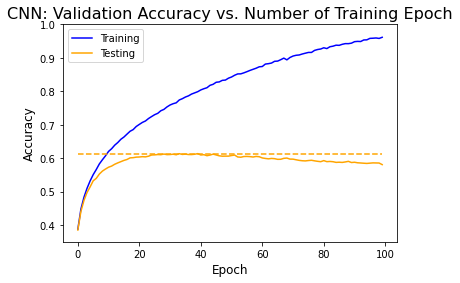

In [0]:
x_val = np.arange(EPOCH)
plt.plot(x_val, np.dot(accuracy_per_trainEpoch,0.01), color='blue', label='Training') # Training
plt.plot(x_val, np.dot(accuracy_per_testEpoch,0.01), color='orange', label='Testing') # Testing
maxVal = np.max(np.dot(accuracy_per_testEpoch,0.01))
maxVal = np.full(len(accuracy_per_testEpoch), maxVal)
plt.plot(x_val, maxVal, '--', color = 'orange')
plt.ylim(0.35, 1) 
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('CNN: Validation Accuracy vs. Number of Training Epoch', fontsize=16)
plt.legend()
plt.savefig('CNN_acc_epoch.png') 
plt.show()

## Performance relative to each class

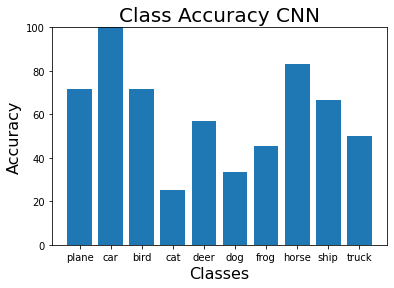

In [0]:
 
img_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
x_val = np.arange(len(img_labels))
y_val = img_acc_list
#plt.ylim(0.0, 0.75) 
plt.bar(x_val, y_val)
plt.xticks(x_val, img_labels)
plt.xlabel('Classes', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Class Accuracy CNN', fontsize=20)
axes = plt.gca()
axes.set_ylim([0,100])
plt.savefig('CNN_class_accuracy.png') 
plt.show()

## Loss vs Epoch

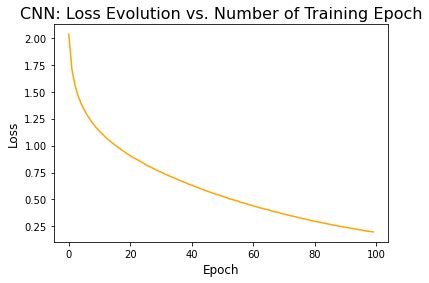

In [0]:
y_val = loss_evolution
x_val = np.arange(len(loss_evolution))

plt.plot(x_val, y_val, color='orange')
maxVal = np.max(y_val)
maxVal = np.full(len(y_val), maxVal)
#plt.plot(x_val, maxVal, '--', color = 'orange')
#plt.ylim(0.25, 3) 
#plt.xticks(x_val, img_labels)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('CNN: Loss Evolution vs. Number of Training Epoch', fontsize=16)
plt.savefig('CNN_loss_evolution.png') 
plt.show()

## Class Category Performance

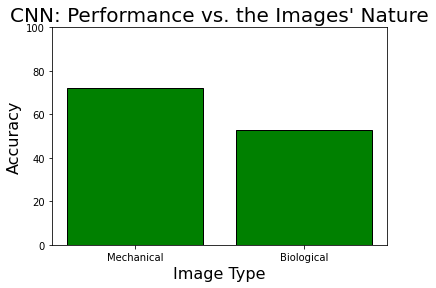

In [0]:
plane = img_acc_list[0]
car = img_acc_list[1]
bird = img_acc_list[2]
cat = img_acc_list[3]
deer = img_acc_list[4]
dog = img_acc_list[5]
frog = img_acc_list[6]
horse = img_acc_list[7]
ship = img_acc_list[8]
truck = img_acc_list[9]

mechanical = [plane, car, ship, truck]
animal = [bird, cat, deer, dog, frog, horse]

mech_acc = np.average(mechanical)
anim_acc = np.average(animal)

x = ["Mechanical", "Biological"]
x_val = np.arange(len(x))
y_val = [mech_acc, anim_acc]
axes = plt.gca()
axes.set_ylim([0,100])
plt.bar(x_val, y_val, color='green', edgecolor='black')
plt.xticks(x_val, x)
plt.xlabel('Image Type', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('CNN: Performance vs. the Images\' Nature', fontsize=20)
plt.savefig('CNN_acc_img_nature.png') 
plt.show()